<a href="https://colab.research.google.com/github/MeharKalra/GESTURON/blob/main/Gesturon_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 26.1 MB/s eta 0:00:00


In [ ]:
import kagglehub

### Downloding Dataset from kaggle

In [ ]:
path = kagglehub.dataset_download("soumicksarker/ipn-hand-dataset")
print("Path to dataset files:", path)
!cp -R /root/.cache/kagglehub/datasets/soumicksarker/ipn-hand-dataset/versions/7 /content

100%|██████████| 4.61G/4.61G [01:23<00:00, 59.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/soumicksarker/ipn-hand-dataset/versions/7


### Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from scipy import stats as st
import mediapipe as mp
from sklearn.utils import resample
import os
from sklearn.decomposition import PCA
from tqdm import tqdm

### The code is divided into following process
    1. Extracting the information from dataset
    2. Performing EDA on information
    3. Extract the landmarks from the frame which will represent the temporal feature
    4. Perform the landmark standardization
    5. Preapre a feature spcae that represent the temporal variation of extracted landmarks
    6. Use a classical ML method or small neural network to classify the gesture based on the variation in temporal features

## Extracting the information from dataset and perfroming EDA

In [ ]:
# Intializing all the possible paths
train_csv_path = "/gesture_frames_Train.csv"
test_csv_path = "/gesture_frames_Test.csv"
metadat_path = "/content/7/annotations/annotations/metadata.xlsx"
class_details_path = "/content/7/annotations/annotations/class_details.txt"
train_annotations_path = "/content/7/annotations/annotations/class_details.txt"
test_annotations_path = "/content/7/annotations/annotations/Annot_TestList.txt"


In [ ]:
def load_data(path):
  dataframe = pd.read_csv(train_csv_path)
  return dataframe

def plot_balance(train_data):
  """
  input : training dataset must contain column of "Label"
  output : Show the number of instances per class in dataset
  """

  grouped = train_data.groupby(["Label"]) #Group data by Labels
  grouped = grouped.size()

  x_axis = grouped.index
  y_axis = []
  for i in range(grouped.shape[0]):
    y_axis.append(grouped.iloc[i])

  #plotting graph
  plt.figure(figsize=(6,4))
  plt.bar(x_axis,y_axis,color="r")
  plt.title("Balance in class distribution")
  plt.xlabel("Class")
  plt.ylabel("Number of gestures")
  plt.xticks(rotation = 90)
  plt.show



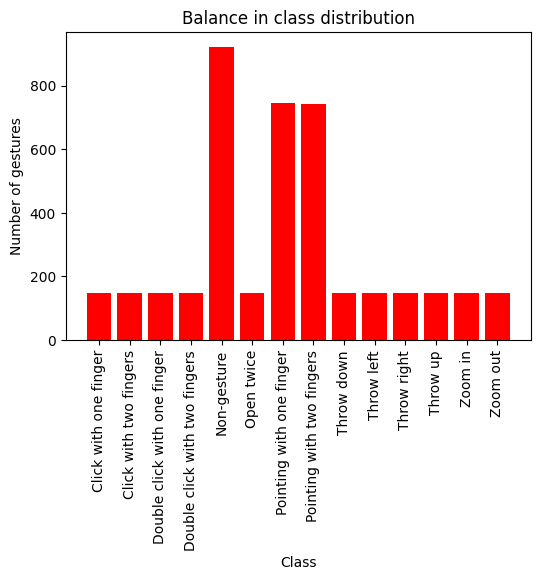

In [ ]:
train_df = load_data(train_csv_path)
plot_balance(train_df)

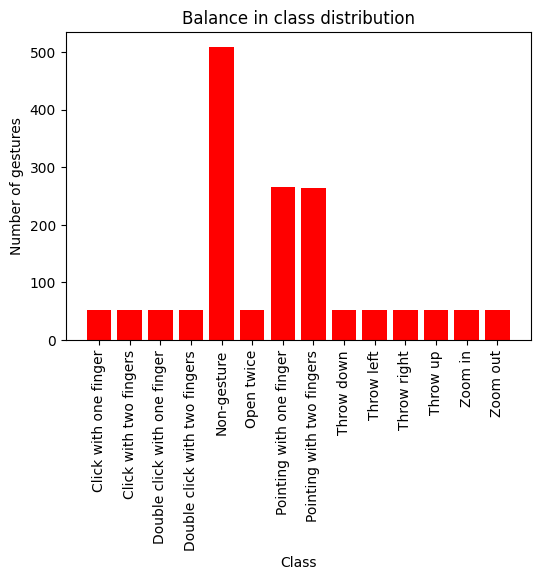

In [ ]:
test_df = pd.read_csv(test_csv_path)
plot_balance(test_df)

In [ ]:
def balance_dataset(dataset):
  max_instances_per_label = dataset['Label'].value_counts().min()
  balanced_df = pd.DataFrame()

  for label in dataset['Label'].unique():
      if label != "Non-gesture":
        label_df = dataset[dataset['Label'] == label]
        sampled_label_df = resample(label_df,
                                    replace=False,  # Do not allow replacement
                                    n_samples=max_instances_per_label,  # Number of samples per label
                                    random_state=42)  # For reproducibility
      else:
        label_df = dataset[dataset['Label'] == label]
        sampled_label_df = resample(label_df,
                                    replace=False,  # Do not allow replacement
                                    n_samples=max_instances_per_label*2,  # Number of samples per label
                                    random_state=42)  # For reproducibility
      balanced_df = pd.concat([balanced_df, sampled_label_df])

  # Shuffle the dataset to mix the labels
  balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
  return balanced_df

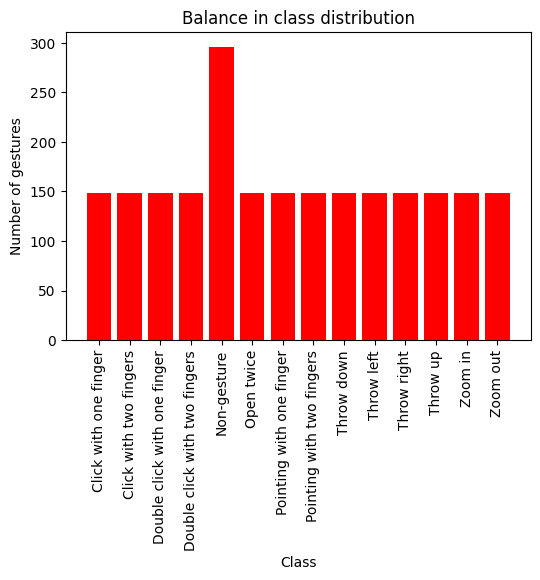

In [ ]:
balanced_train_df = balance_dataset(train_df)
plot_balance(balanced_train_df)

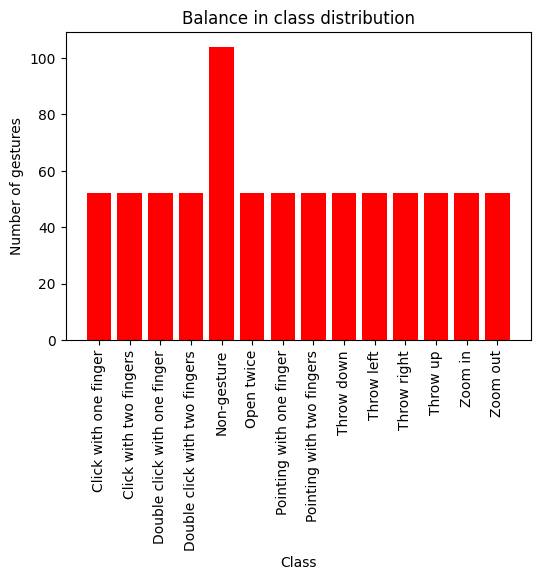

In [ ]:
balanced_test_df =  balance_dataset(test_df)
plot_balance(balanced_test_df)

## Extract the landmarks from the frame which will represent the temporal feature and Perform the landmark standardization

In [ ]:
#Visualization of number of frames captured for each gesture
def frame_length(dataframe):
  frame_length = []
  for i in dataframe["Frames"]:
      i = eval(i)
      frame_length.append(len(i))

  length_dict = {}
  for length in frame_length:
    key = length
    if key not in length_dict:
        value = frame_length.count(length)
        length_dict[key] = value

  print("Minimum frame length",min(frame_length ))
  print("Maximum frame length",max(frame_length))
  print("Mean Frame Length ",np.mean(frame_length))

  plt.figure(figsize=(15,5))
  plt.bar(length_dict.keys() , length_dict.values())
  plt.title('Count of frame length')
  plt.xlabel('Frame Length')
  plt.ylabel('Numbet of gesture')
  plt.show()

In [ ]:
def Remove_outlier(dataframe):
  count = 0
  for i in dataframe["Frames"]:
      index = dataframe.index[dataframe["Frames"]==i] #index of the frame
      i = eval(i)
      frame_length = len(i) #Length of the frames
      if frame_length >=400 or frame_length<= 20:
        count += 1
        dataframe.drop(index,inplace=True)

  print("Removed Instances",count)
  return dataframe



Minimum frame length 9
Maximum frame length 922
Mean Frame Length  99.38243243243244


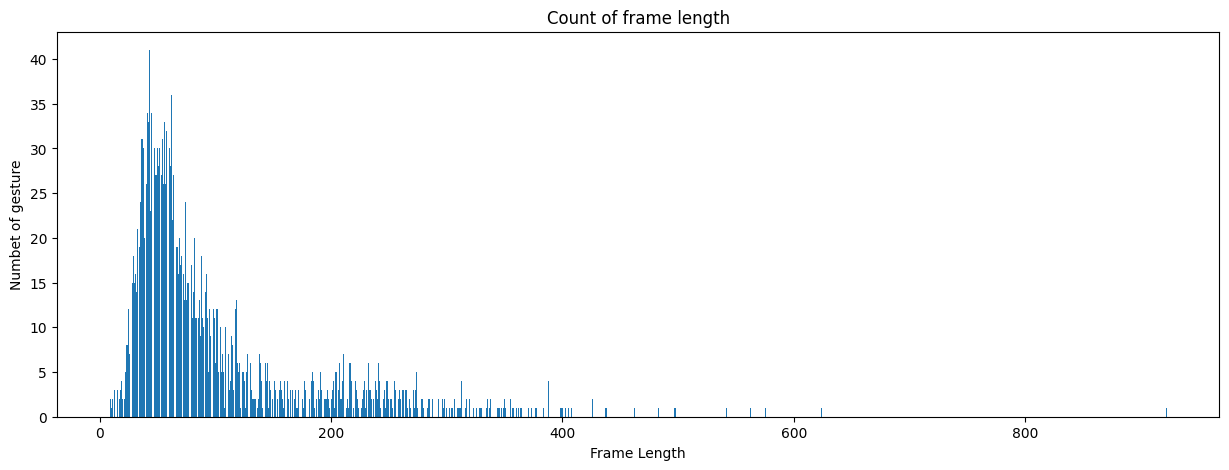

In [ ]:
frame_length(balanced_train_df)

Removed Instances 45
Minimum frame length 21
Maximum frame length 399
Mean Frame Length  96.62988505747127


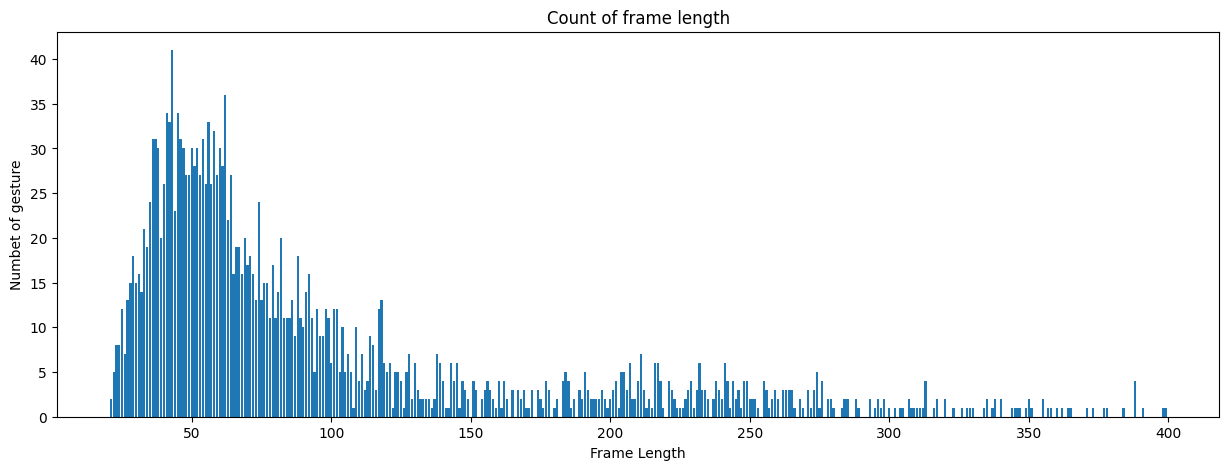

In [ ]:
balanced_new_df = Remove_outlier(balanced_train_df)
frame_length(balanced_new_df)

Removed Instances 18
Minimum frame length 21
Maximum frame length 396
Mean Frame Length  90.51312335958005


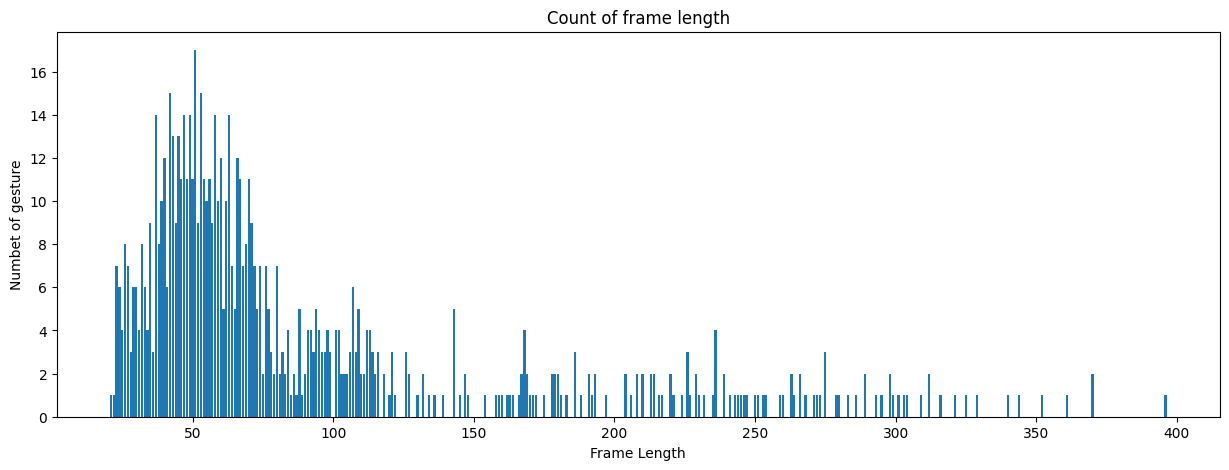

In [ ]:
balanced_new_df1 = Remove_outlier(balanced_test_df)
frame_length(balanced_new_df1)

In [ ]:
def evaluate_path(tck, num_points=100):
    u_fine = np.linspace(0, 1, num_points)
    x_fine, y_fine, z_fine = splev(u_fine, tck)
    return np.array([x_fine, y_fine, z_fine]).T

In [ ]:
import time

In [ ]:
def get_flow_vector(dataset):
  # Initialize MediaPipe Hands
  total_iterations = dataset.shape[0]
  #progress_bar = tqdm(total=total_iterations, desc="Processing", unit="step")

  mp_hands = mp.solutions.hands
  hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)

  pca = PCA(n_components=10)
  significant_landmark = [0,1,4,5,8,9,12,13,16,17,20]

  # To store flow vectors
  flow_vectors = []
  flow_vectors_pca = []
  flow_vector_significat = []
  Labels = []

  video_dir = '/content/7/videos/videos'
  for index, row in tqdm(dataset.iterrows()):
      label = row['Label']
      video_id = row['Video_ID']
      frame_indices = eval(row['Frames'])

      video_path = os.path.join(video_dir, f"{video_id}.avi")
      if not os.path.exists(video_path):
          print(f"Video file not found: {video_path}")
          continue

      cap = cv2.VideoCapture(video_path)
      if not cap.isOpened():
          print(f"Error opening video file: {video_path}")
          continue

      # To store landmarks for the frames in the current gesture
      gesture_landmarks = []

      for frame_idx in frame_indices:
          cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx - 1)
          ret, frame = cap.read()
          if not ret:
              print(f"Error reading frame {frame_idx} from video {video_id}")
              continue

          frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          results = hands.process(frame_rgb)

          if results.multi_hand_landmarks:
              # Use the first detected hand
              hand_landmarks = results.multi_hand_landmarks[0]
              landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
              gesture_landmarks.append(landmarks)

      cap.release()
      gesture_landmarks = np.array(gesture_landmarks)
      scaled_landmarks = np.zeros((50,21,3))


      if len(gesture_landmarks)<2:
        continue

      try:
        for i in range(20):
          # i is the index of landmark
          x, y, z = gesture_landmarks[:,i,0], gesture_landmarks[:,i,1],gesture_landmarks[:,i,2]

          # Create a spline representation of the path
          tck, u = splprep([x, y, z], s=0)
          path = evaluate_path(tck, num_points=50)
          x_path = path[:,0]
          y_path = path[:,1]
          z_path = path[:,2]

          for j in range(len(path)):
            scaled_landmarks[j][i][0] = x_path[j]
            scaled_landmarks[j][i][1] = y_path[j]
            scaled_landmarks[j][i][2] = z_path[j]


        if len(scaled_landmarks) > 1:
                # Convert to NumPy array: Shape (T, 21, 3)
                scaled_landmarks = np.array(scaled_landmarks)

                # Compute temporal differences: Shape (T-1, 21, 3)
                temporal_diff = np.diff(scaled_landmarks, axis=0)

                # Flatten each frame's differences into a 1D vector: Shape (T-1, 63)
                flow_vector = temporal_diff.reshape(temporal_diff.shape[0], -1)
                flow_vector_flatten = flow_vector.flatten()
                #print(flow_vector_flatten.shape)

                # Apply PCA to reduce dimensions
                flow_vector_reduced = pca.fit_transform(flow_vector)  # Shape: (T-1, 10)
                flow_vector_reduced_flatten =  flow_vector_reduced.flatten()
                #print(flow_vector_reduced_flatten.shape)

                flow_vector_significant = np.array([])
                #Extracting the significant features only
                for i in significant_landmark:
                  flow_vector_significant = np.concatenate((flow_vector_significant, flow_vector[i]))
                flow_vector_significant_flatten = flow_vector_significant.flatten()


                # Save the reduced flow vector and label
                flow_vectors.append(flow_vector_flatten)
                flow_vectors_pca.append(flow_vector_reduced_flatten)
                flow_vector_significat.append(flow_vector_significant_flatten)
                Labels.append(label)
        #time.sleep(0.01)
      except:
        print("Error at idx:" ,index)
        continue
      #progress_bar.update(1)
      #time.sleep(0.01)

  #progress_bar.close()

  print("Processing complete!")
  hands.close()

  return flow_vectors,flow_vectors_pca,flow_vector_significat,Labels


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/My Drive/My Folder"

In [ ]:
balanced_new_df.shape

(2175, 3)

In [ ]:
train_flow_vector,train_flow_vectors_pca,train_flow_vectors_significat,Labels =  get_flow_vector(balanced_new_df)

43it [04:59,  5.59s/it]

Error at idx: 44


49it [05:36,  5.40s/it]

Error at idx: 50


50it [05:53,  9.02s/it]

Error at idx: 51


104it [12:20, 12.69s/it]

Error at idx: 107


109it [12:47,  5.96s/it]

Error at idx: 113


180it [21:08,  8.87s/it]

Error at idx: 188


186it [21:54,  7.69s/it]

Error at idx: 194


188it [22:15,  8.47s/it]

Error at idx: 196


218it [27:48,  5.71s/it]

Error at idx: 226


222it [28:42, 13.20s/it]

Error at idx: 230


253it [32:09, 10.30s/it]

Error at idx: 261


262it [33:31,  8.96s/it]

Error at idx: 271


310it [39:51,  9.07s/it]

Error at idx: 319


320it [40:33,  3.59s/it]

Error at idx: 329


324it [40:54,  4.59s/it]

Error at idx: 333


374it [47:04,  8.02s/it]

Error at idx: 385


388it [48:43,  9.51s/it]

Error at idx: 400


408it [50:17,  4.75s/it]

Error reading frame 3684 from video 4CM11_19_R__19


448it [54:43,  5.90s/it]

Error at idx: 460


458it [55:35,  4.11s/it]

Error at idx: 470


485it [58:42,  8.00s/it]

Error at idx: 498


487it [59:15, 12.77s/it]

Error at idx: 500


488it [59:28, 12.76s/it]

Error reading frame 15 from video 1CM1_4_R__230
Error reading frame 16 from video 1CM1_4_R__230
Error reading frame 17 from video 1CM1_4_R__230
Error reading frame 18 from video 1CM1_4_R__230
Error reading frame 19 from video 1CM1_4_R__230
Error reading frame 20 from video 1CM1_4_R__230
Error reading frame 21 from video 1CM1_4_R__230
Error reading frame 22 from video 1CM1_4_R__230
Error reading frame 23 from video 1CM1_4_R__230
Error reading frame 24 from video 1CM1_4_R__230


525it [1:03:45,  6.88s/it]

Error at idx: 542


562it [1:08:02,  7.05s/it]

Error reading frame 25 from video 1CM1_4_R__229
Error reading frame 26 from video 1CM1_4_R__229


574it [1:09:53, 12.92s/it]

Error at idx: 591


582it [1:10:33,  5.13s/it]

Error at idx: 600


622it [1:16:03,  4.86s/it]

Error at idx: 640


627it [1:16:35,  4.72s/it]

Error at idx: 645


661it [1:20:29, 10.21s/it]

Error at idx: 679


668it [1:21:11,  5.11s/it]

Error at idx: 687


672it [1:21:42,  6.27s/it]

Error at idx: 691


687it [1:23:05,  8.50s/it]

Error at idx: 708


723it [1:27:27, 10.83s/it]

Error at idx: 745


724it [1:27:31,  8.55s/it]

Error at idx: 746


730it [1:28:29,  7.20s/it]

Error at idx: 752


827it [1:40:08,  7.61s/it]

Error at idx: 850


870it [1:45:13,  8.62s/it]

Error at idx: 893


920it [1:50:37,  8.76s/it]

Error at idx: 944


1022it [2:02:06,  5.95s/it]

Error at idx: 1046


1025it [2:02:27,  7.21s/it]

Error at idx: 1049


1047it [2:04:36, 10.14s/it]

Error at idx: 1071


1056it [2:05:34,  8.06s/it]

Error at idx: 1080


1064it [2:06:21,  6.63s/it]

Error at idx: 1088


1111it [2:10:56,  9.42s/it]

Error at idx: 1137


1123it [2:12:42,  7.25s/it]

Error at idx: 1149


1220it [2:23:39,  3.95s/it]

Error at idx: 1249


1273it [2:29:18, 10.39s/it]

Error at idx: 1302


1276it [2:29:35,  7.17s/it]

Error at idx: 1305


1319it [2:36:39,  6.13s/it]

Error at idx: 1349


1326it [2:36:57,  3.02s/it]

Error at idx: 1356


1347it [2:41:29,  9.66s/it]

Error at idx: 1378


1348it [2:41:31,  7.22s/it]

Error reading frame 4077 from video 1CM42_6_R__161


1381it [2:45:22,  6.41s/it]

Error at idx: 1412


1400it [2:47:30,  8.27s/it]

Error at idx: 1431


1418it [2:49:16,  5.59s/it]

Error at idx: 1451


1456it [2:54:24,  4.33s/it]

Error at idx: 1489


1534it [3:02:39,  4.06s/it]

Error at idx: 1569


1548it [3:04:01,  7.87s/it]

Error at idx: 1583


1595it [3:09:48,  7.79s/it]

Error at idx: 1630


1634it [3:13:19,  4.30s/it]

Error at idx: 1669


1699it [3:20:25,  8.10s/it]

Error at idx: 1736


1721it [3:23:28,  6.91s/it]

Error at idx: 1758


1730it [3:24:45,  8.88s/it]

Error at idx: 1767


1767it [3:29:09,  8.35s/it]

Error at idx: 1805


1776it [3:29:53,  5.06s/it]

Error reading frame 21 from video 1CM1_4_R__232
Error reading frame 22 from video 1CM1_4_R__232
Error reading frame 23 from video 1CM1_4_R__232
Error reading frame 24 from video 1CM1_4_R__232
Error reading frame 25 from video 1CM1_4_R__232
Error reading frame 26 from video 1CM1_4_R__232


1797it [3:33:02, 14.49s/it]

Error at idx: 1838


1821it [3:35:57,  7.72s/it]

Error at idx: 1862


1908it [3:47:17,  7.32s/it]

Error at idx: 1950


1956it [3:54:15,  9.20s/it]

Error at idx: 1998


1962it [3:54:49,  8.34s/it]

Error at idx: 2004


1972it [3:55:33,  4.71s/it]

Error at idx: 2014


2000it [3:58:51,  8.06s/it]

Error at idx: 2042


2065it [4:04:49,  4.72s/it]

Error at idx: 2108


2069it [4:05:35, 11.21s/it]

Error at idx: 2112


2112it [4:12:15, 20.45s/it]

Error at idx: 2155


2125it [4:13:55,  9.19s/it]

Error at idx: 2168


2140it [4:15:28,  3.58s/it]

Error at idx: 2183


2145it [4:15:53,  5.02s/it]

Error at idx: 2188


2150it [4:16:47,  9.88s/it]

Error reading frame 15 from video 1CM1_4_R__231
Error reading frame 16 from video 1CM1_4_R__231
Error reading frame 17 from video 1CM1_4_R__231
Error reading frame 18 from video 1CM1_4_R__231
Error reading frame 19 from video 1CM1_4_R__231
Error reading frame 20 from video 1CM1_4_R__231
Error reading frame 21 from video 1CM1_4_R__231
Error reading frame 22 from video 1CM1_4_R__231


2168it [4:18:56,  4.05s/it]

Error at idx: 2212


2175it [4:20:01,  7.17s/it]


Processing complete!


In [ ]:
df = pd.DataFrame(train_flow_vector)
#df.to_csv("/content/train_flow_vector.csv")

label_df = pd.read_csv("/Labels.csv")
#label_df.to_csv("/content/Labels.csv")

In [ ]:
test_flow_vector,test_flow_vectors_pca,test_flow_vectors_significat,Labels =  get_flow_vector(balanced_new_df1)

38it [03:20,  8.28s/it]

Error at idx: 38


51it [04:39,  4.26s/it]

Error at idx: 52


53it [05:06,  9.99s/it]

Error at idx: 54


115it [11:15,  4.38s/it]

Error at idx: 119


247it [29:25,  9.59s/it]

Error at idx: 253


307it [37:17,  7.39s/it]

Error at idx: 315


345it [42:14,  6.99s/it]

Error at idx: 353


372it [44:54,  4.36s/it]

Error at idx: 380


483it [57:42,  6.06s/it]

Error at idx: 494


518it [1:01:22,  6.08s/it]

Error at idx: 529


659it [1:15:52,  5.56s/it]

Error at idx: 672


731it [1:23:20,  4.45s/it]

Error at idx: 745


762it [1:26:53,  6.84s/it]

Processing complete!


In [ ]:
df3 = pd.DataFrame(test_flow_vector)
df3.to_csv("/content/test_flow_vector.csv")

label_df1 = pd.DataFrame(Labels)
label_df1.to_csv("/content/Labels.csv")